In [57]:
import xarray as xa
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import lib.atmosphere as atm
import lib.physics as phy
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fds = xa.open_dataset('./forcings/southern_nz_6a_icar-095_erai_165,176,-48,-40_30-04-2015-to-01-06-2015.nc')

In [3]:
Nx = fds.west_east.shape[0]
Ny = fds.south_north.shape[0]
Nz = fds.bottom_top.shape[0]
Nt = fds.Time.shape[0]

fds

<xarray.Dataset>
Dimensions:  (Time: 136, bottom_top: 60, south_north: 14, west_east: 18)
Coordinates:
  * Time     (Time) datetime64[ns] 2015-04-30 ... 2015-06-02T18:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    XLONG    (Time, south_north, west_east) float64 ...
    XLAT     (Time, south_north, west_east) float64 ...
    HGT      (Time, south_north, west_east) float32 ...
    U        (Time, bottom_top, south_north, west_east) float32 ...
    V        (Time, bottom_top, south_north, west_east) float32 ...
    P        (Time, bottom_top, south_north, west_east) float64 ...
    PH       (Time, bottom_top, south_north, west_east) float64 ...
    QVAPOR   (Time, bottom_top, south_north, west_east) float32 ...
    QCLOUD   (Time, bottom_top, south_north, west_east) float32 ...
    QICE     (Time, bottom_top, south_north, west_east) float32 ...
    PB       (Time, bottom_top, south_north, west_east) float64 ...
    PHB      (Time, bottom_top, 

In [4]:
nx = 9
ny = 7
nt = 5

In [33]:
N_arr = np.zeros(Nt*Nz*Ny*Nx).reshape(Nt,Nz,Ny,Nx)
N2_arr = np.zeros(Nt*Nz*Ny*Nx).reshape(Nt,Nz,Ny,Nx)

In [6]:
TABS = atm.t_from_tpot(tpot=fds['TH'].values,p=fds['P'].values)

In [46]:
N_min = 1*10**-7
N_max = 6*10**-4

# this would have to consider snow and ice as well, but ERAI doesn't calculate those.
MRMOISTURE = fds['QCLOUD'].values+fds['QICE'].values

for nt in range(Nt):
    if nt%10 == 0:
        print('timestep {:n}/{:n}'.format(nt,Nt))
        
    for nx in range(Nx):
        for ny in range(Ny):
            z_arr = fds.PH[nt,:,ny,nx]
            th_arr = fds.TH[nt,:,ny,nx]
                    
                    # decide whether to calculate dry or moist stability:
            mrmoisture_arr = MRMOISTURE[nt,:,ny,nx]
            
            N2_col  = np.zeros(Nz)
            N2m_col = np.zeros(Nz)
            
            N2_col[:-1] = atm.calc_dry_stability_squared(
                    th_top = th_arr[1:],
                    th_bot = th_arr[:-1],
                    z_top  = z_arr[1:],
                    z_bot  = z_arr[:-1]
                )
            
            if len(mrmoisture_arr[mrmoisture_arr <  10**-7] > 0):
                N2m_col[:-1] = atm.calc_moist_stability_squared(
                    t_top   = TABS[nt,n+1,ny,nx],
                    t_bot   = TABS[nt,n,ny,nx],
                    mrv_top = fds['QVAPOR'].values[nt,n+1,ny,nx],
                    mrv_bot = fds['QVAPOR'].values[nt,n,ny,nx],
                    mrc     = fds['QCLOUD'].values[nt,n,ny,nx],
                    z_top   = z_arr[n+1],
                    z_bot   = z_arr[n]
                )    
            
            N2_col[-1]  = N2_col[-2]
            N2m_col[-1] = N2m_col[-2]
            
            N2_col[ (N2_col  < 0) | (N2_col  < N_min)] = N_min
            N2m_col[(N2m_col < 0) | (N2m_col < N_min)] = N_min
            
            N2_col[ N2_col  > N_max] = N_max
            N2m_col[N2m_col > N_max] = N_max
            
            N2_arr[nt,:,ny,nx][mrmoisture_arr <  10**-7] = N2_col[mrmoisture_arr <  10**-7]
            N2_arr[nt,:,ny,nx][mrmoisture_arr >= 10**-7] = N2m_col[mrmoisture_arr >= 10**-7]

timestep 0/136
timestep 10/136
timestep 20/136
timestep 30/136
timestep 40/136
timestep 50/136
timestep 60/136
timestep 70/136
timestep 80/136
timestep 90/136
timestep 100/136
timestep 110/136
timestep 120/136
timestep 130/136


In [55]:
N_arr = np.sqrt(N2_arr)

In [7]:
N_min = np.sqrt(1*10**-7)
N_max = np.sqrt(6*10**-4)

for nt in range(Nt):
    if nt%10 == 0:
        print('timestep {:n}/{:n}'.format(nt,Nt))
    
    for nx in range(Nx):
        for ny in range(Ny):
            z_arr = fds.PH[nt,:,ny,nx].values
            th_arr = fds.TH[nt,:,ny,nx].values
            
            lth1 = np.log(th_arr[1:])
            lth0 = np.log(th_arr[:-1])
            dlth = lth1-lth0
            dz   = z_arr[1:]-z_arr[:-1]
            frac      = np.zeros(Nz)
            frac[:-1] = dlth/dz
            frac[-1]  = frac[-2]

            N_arr[nt,:,ny,nx][frac<0]=N_min
            N_arr[nt,:,ny,nx][frac>=0]=np.sqrt(9.81*(frac[frac>=0]))
            N_arr[nt,:,ny,nx][N_arr[nt,:,ny,nx]<N_min] = N_min
            N_arr[nt,:,ny,nx][N_arr[nt,:,ny,nx]>N_max] = N_max

timestep 0/136
timestep 10/136
timestep 20/136
timestep 30/136
timestep 40/136
timestep 50/136
timestep 60/136
timestep 70/136
timestep 80/136
timestep 90/136
timestep 100/136
timestep 110/136
timestep 120/136
timestep 130/136


In [8]:
lr = atm.calc_sat_lapse_rate(T=TABS,mr=fds['QVAPOR'].values)

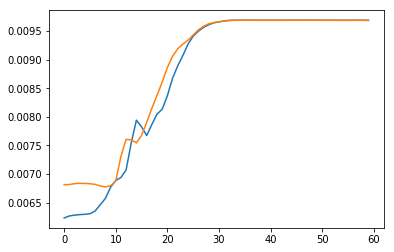

In [14]:
plt.plot(lr[0,:,0,0])
plt.plot(lr[0,:,6,5])

In [7]:
N_arr = np.zeros(Nt*Nz*Ny*Nx).reshape(Nt,Nz,Ny,Nx)

In [32]:
N_min = 1*10**-7
N_max = 6*10**-4

# this would have to consider snow and ice as well, but ERAI doesn't calculate those.
MRMOISTURE = fds['QCLOUD'].values+fds['QICE'].values

for nt in range(1):
    #if nt%10 == 0:
    print('timestep {:n}/{:n}'.format(nt,Nt))
        
    for nx in range(Nx):
        for ny in range(Ny):
            z_arr = fds.PH[nt,:,ny,nx]
            th_arr = fds.TH[nt,:,ny,nx]
            for n, z in enumerate(z_arr):
                if n < len(z_arr)-1:
                    
                    # decide whether to calculate dry or moist stability:
                    

                    if MRMOISTURE[nt,n,ny,nx] < 10**-7:
                        N2 = atm.calc_dry_stability_squared(
                            th_top = th_arr[n+1],
                            th_bot = th_arr[n],
                            z_top  = z_arr[n+1],
                            z_bot  = z_arr[n]
                        )
                    else:
                        N2 = atm.calc_moist_stability_squared(
                            t_top   = TABS[nt,n+1,ny,nx],
                            t_bot   = TABS[nt,n,ny,nx],
                            mrv_top = fds['QVAPOR'].values[nt,n+1,ny,nx],
                            mrv_bot = fds['QVAPOR'].values[nt,n,ny,nx],
                            mrc     = fds['QCLOUD'].values[nt,n,ny,nx],
                            z_top   = z_arr[n+1],
                            z_bot   = z_arr[n]
                        )    
                    
                    if N2 < 0:
                        N   = N_min
                    else:
                        N   = np.sqrt(N2)

                        
                        
                    if N < N_min:
                        N = N_min
                    elif N > N_max:
                        N = N_max
                    
                    N_arr[nt,n,ny,nx] = N
                                      
            N_arr[nt,-1,ny,nx] = N_arr[nt,-2,ny,nx]

timestep 0/136


KeyboardInterrupt: 

In [28]:
nt

0

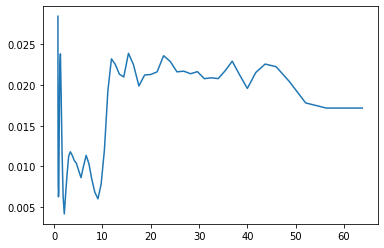

In [23]:
plt.plot(z_arr/1000,N_arr)

In [62]:
frac.shape

(60,)

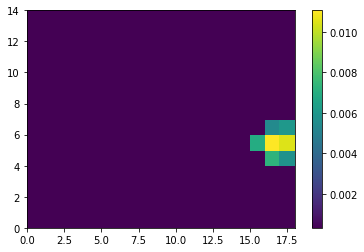

In [19]:
plt.pcolormesh(N_arr[0,5,:])
plt.colorbar()

In [ ]:
plt.pcolormesh()